# OBJECTIVE :- Apply DBSCAN on Amazon Fine Food Reviews

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


# NOTE :- My laptop got hang badly even with 40K datapoints . So I am performing this assignment only on 10K datapoints . My laptop has only 8GB RAM and unable to perform it with whole dataset . But I will complete all the tasks as was asked in the assignment

RANDOMLY SAMPLING 10K POINTS OUT OF WHOLE DATASET

In [10]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 10K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:10000])

x = my_final['CleanedText'].values

# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 500) 
data_vec = count_vect.fit_transform(x)
print("the type of count vectorizer :",type(data_vec))
print("the shape of out text BOW vectorizer : ",data_vec.get_shape())
print("the number of unique words :", data_vec.get_shape()[1])

# Converting sparse matrix to dense matrix
data_dense = data_vec.toarray()

# Standardising the data
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(data_dense)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (10000, 116)
the number of unique words : 116


# Function To Compute Distance of nth-nearesr neighbour

In [12]:
# function to determinethe distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))    

# Function to call DBSCAN

In [16]:
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

ELBOW METHOD TO FIND RIGHT EPSILON :

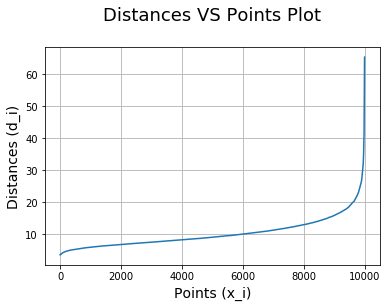

In [17]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 16 because after that there is sharp rise in the value of distances (d_i's)

# DBSCAN Implementation

In [18]:
optimal_eps = 16
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 18
db2 = dbscan(18, min_points, data)


# Clustering with epsilon = 20
db3 = dbscan(20, min_points, data)


# Clustering with epsilon = 22
db4 = dbscan(22, min_points, data)

Number of clusters for MinPts = 232 and Epsilon = 16.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 18.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 20.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 22.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



# Visualizing The Clusters :

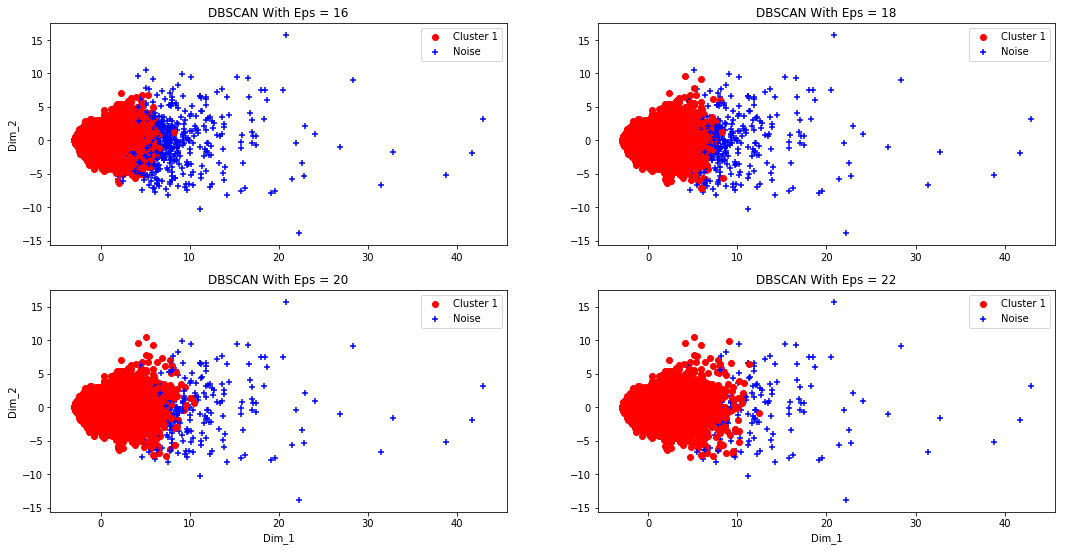

In [28]:
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 16
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 16')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 18
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 18')

# Scatter plot for DBSCAN with Eps = 20
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 20')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 22
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 22')
plt.xlabel('Dim_1')

plt.show()

# (2) TFIDF

In [29]:
tf_idf_vect = TfidfVectorizer(min_df=500)
data_vec = tf_idf_vect.fit_transform(x)
print("the type of count vectorizer :",type(data_vec))
print("the shape of out text BOW vectorizer : ",data_vec.get_shape())
print("the number of unique words :", data_vec.get_shape()[1])

# Converting sparse matrix to dense matrix
data_dense = data_vec.toarray()

# Standardising the data
data = StandardScaler().fit_transform(data_dense)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (10000, 116)
the number of unique words : 116


ELBOW METHOD TO FIND RIGHT EPSILON :

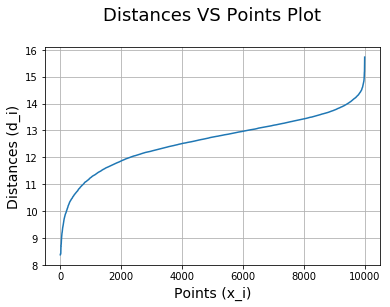

In [30]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 9 because after that there is sharp rise in the value of distances (d_i's)

# DBSCAN Implementation

In [35]:
optimal_eps = 9
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 10
db2 = dbscan(10, min_points, data)


# Clustering with epsilon = 11
db3 = dbscan(11, min_points, data)


# Clustering with epsilon = 12
db4 = dbscan(12, min_points, data)

Number of clusters for MinPts = 232 and Epsilon = 9.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 11.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 232 and Epsilon = 12.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



# Visualizing The Clusters :

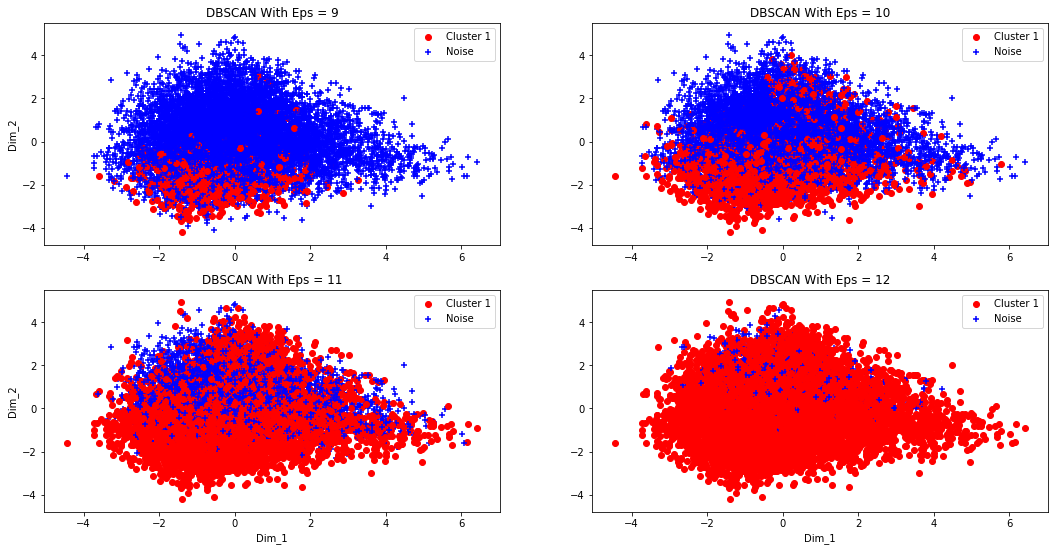

In [36]:
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 9
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 9')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 10
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 10')

# Scatter plot for DBSCAN with Eps = 11
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 11')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 12
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1,c2], ['Cluster 1','Noise'])  
plt.title('DBSCAN With Eps = 12')
plt.xlabel('Dim_1')

plt.show()

# Word2Vec

In [37]:
# List of sentence in X_train text
sent_x = []
for sent in x :
    sent_x.append(sent.split())
  
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_x,min_count=5,size=100, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  4563


# (3). Avg Word2Vec

In [38]:
# compute average word2vec for each review for sent_x .
train_vectors = []; 
for sent in sent_x:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
#Standardising the data
data = StandardScaler().fit_transform(train_vectors)

ELBOW METHOD TO FIND RIGHT EPSILON :

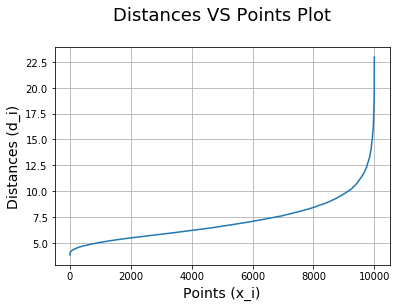

In [39]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 10 because after that there is sharp rise in the value of distances (d_i's)

# DBSCAN Implementation

In [40]:
optimal_eps = 10
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(11, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(12, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(13, min_points, data)

Number of clusters for MinPts = 200 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 11.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 12.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 13.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



# Visualizing The Clusters :

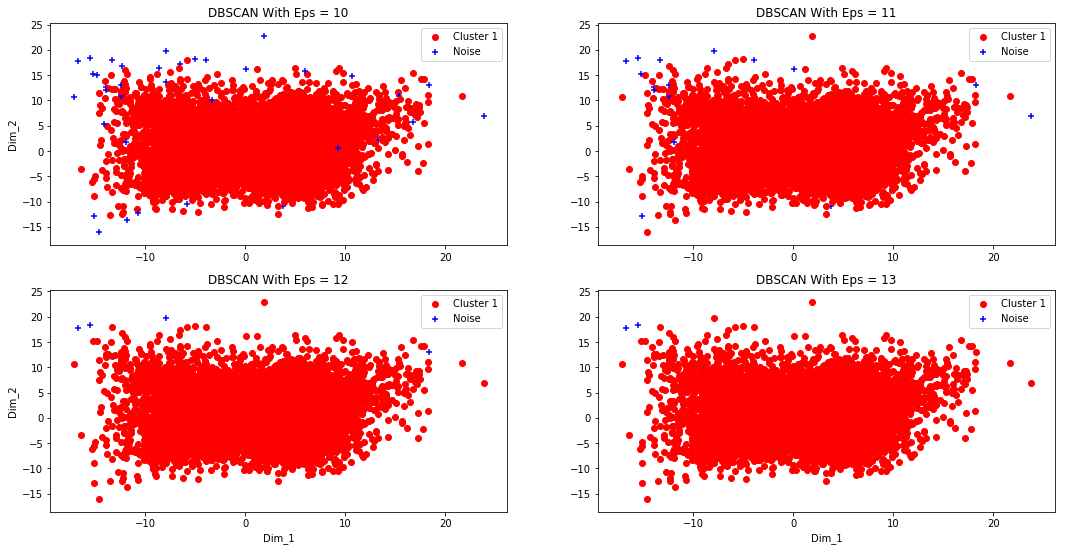

In [41]:
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 10
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 10')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 11
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 11')

# Scatter plot for DBSCAN with Eps = 12
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 12')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 13
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1,c2], ['Cluster 1','Noise'])  
plt.title('DBSCAN With Eps = 13')
plt.xlabel('Dim_1')

plt.show()

# (4). TFIDF-Word2Vec

In [42]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(x)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for sent_x .
tfidf_vectors = []; 
row=0;
for sent in sent_x: 
    sent_vec = np.zeros(100) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
#Standardising the data
data = StandardScaler().fit_transform(tfidf_vectors)

ELBOW METHOD TO FIND RIGHT EPSILON :

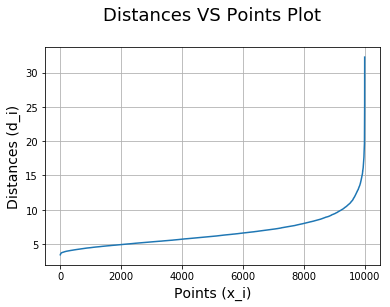

In [43]:
min_points = 2*data.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 10 because after that there is sharp rise in the value of distances (d_i's)

# DBSCAN Implementation

In [44]:
optimal_eps = 10
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data)


# Clustering with  epsilon = 11
db2 = dbscan(11, min_points, data)


# Clustering with epsilon = 12
db3 = dbscan(12, min_points, data)


# Clustering with epsilon = 13
db4 = dbscan(13, min_points, data)

Number of clusters for MinPts = 200 and Epsilon = 10.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 11.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 12.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 200 and Epsilon = 13.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



# Visualizing The Clusters :

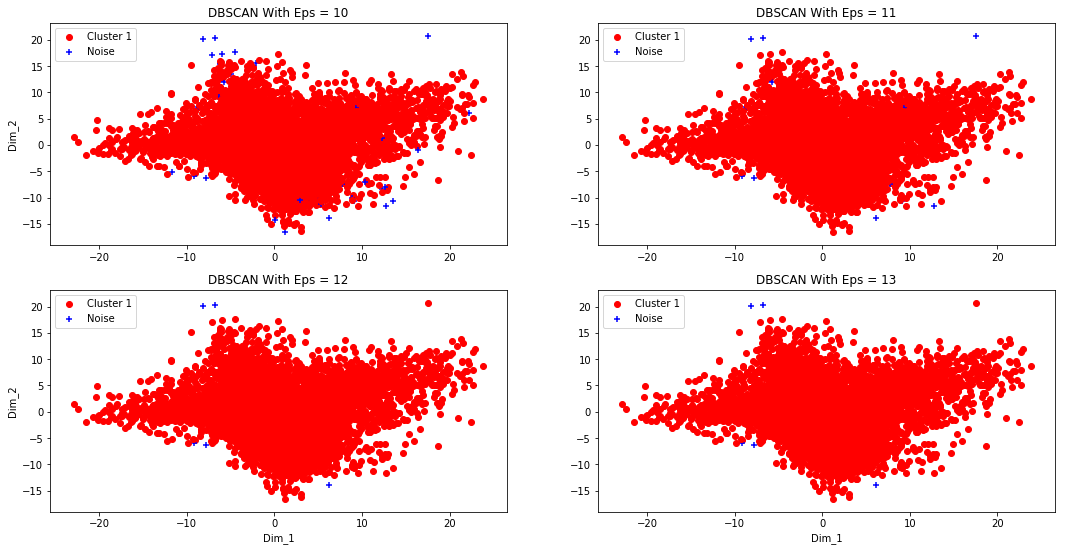

In [45]:
pca_2d = PCA(n_components=2).fit_transform(data)

# Scatter plot for DBSCAN with Eps = 10
plt.figure(figsize=(18,9))
plt.subplot(221)
for i in range(0, pca_2d.shape[0]):
    if db1.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db1.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 10')
plt.ylabel('Dim_2')

# Scatter plot for DBSCAN with Eps = 11
plt.subplot(222)
for i in range(0, pca_2d.shape[0]):
    if db2.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db2.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 11')

# Scatter plot for DBSCAN with Eps = 12
plt.subplot(223)
for i in range(0, pca_2d.shape[0]):
    if db3.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db3.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1, c2], ['Cluster 1', 'Noise'])  
plt.title('DBSCAN With Eps = 12')
plt.ylabel('Dim_2')
plt.xlabel('Dim_1')

# Scatter plot for DBSCAN with Eps = 13
plt.subplot(224)
for i in range(0, pca_2d.shape[0]):
    if db4.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='o')
    elif db4.labels_[i] == -1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='+')
plt.legend([c1,c2], ['Cluster 1','Noise'])  
plt.title('DBSCAN With Eps = 13')
plt.xlabel('Dim_1')

plt.show()

# CONCLUSION :-

#  Procedure Followed :

STEP 1 :- Text Preprocessing

STEP 2 :- Taking all text data and ignoring class variable .

STEP 3:- Training the vectorizer on text_data and later applying same vectorizer on text_data to transform it into vectors

STEP 4:- Standardizing the vectorized data

STEP 5:- Applying the Elbow Method in order to find the right value of Epsilon

STEP 6:- Draw distances VS points plot

STEP 7:- Implementing DBSCAN with various values of Epsilon including the optimal value of Epsilon

STEP 8:- Draw Scatter plots for DBSCAN with various Epsilon values

Repeat from STEP 3 to STEP 8 for each of these four vectorizers : Bag Of Words(BoW), TFIDF, Avg Word2Vec and TFIDF Word2Vec